In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection
from sklearn import metrics

### Učitavanje i priprema podataka

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.drop(columns=['Unnamed: 0'], inplace = True)

In [4]:
y = data.iloc[:, -1]
X = data.iloc[:, :data.shape[1] - 1]

In [5]:
number_of_columns = X.shape[1]
number_of_rows = X.shape[0]
number_of_classes = len(np.unique(y))

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

Standardizujemo sve podatke:

In [7]:
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_knn = scaler.transform(X)

In [8]:
X_knn.shape

(11500, 178)

In [9]:
X_knn[:10, :]

array([[ 0.88505134,  1.20992878,  1.46276429, ..., -0.63414367,
        -0.43329036, -0.23539922],
       [ 2.40057718,  2.36619038,  2.23944096, ...,  1.02342937,
         0.95424076,  0.85653664],
       [-0.12328657, -0.16915405, -0.22513147, ..., -0.13687176,
        -0.13859348, -0.14440456],
       ...,
       [ 0.07596583,  0.05366719,  0.01337554, ..., -0.3271857 ,
        -0.27366289, -0.16260349],
       [-1.60862265, -1.41574858, -1.25254628, ..., -0.68939611,
        -0.40873229, -0.1686698 ],
       [ 0.11823149,  0.15604452,  0.14180239, ..., -0.01408857,
        -0.01580312,  0.0072532 ]])

Parametri koje cemo koristiti za izbor i evaluaciju najboljeg modela:

In [10]:
knn_par = {'n_neighbors': [3, 5, 7, 9]}
k = 10

In [12]:
classes = np.unique(y)

Pravimo posebne metrike koje koristimo za evaluaciju (f1_score po svim klasama):

In [13]:
scoring = {'f1_macro' : 'f1_macro', 'accuracy' : 'accuracy'}
for c in classes:
    def f1_class(y_true, y_pred, classes, c=c):
        return metrics.f1_score(y_true, y_pred, average=None)[c-1]
    scoring_name = 'f1_class_%d' % c
    scoring[scoring_name] = metrics.make_scorer(f1_class, classes = classes)

In [14]:
scoring

{'f1_macro': 'f1_macro',
 'accuracy': 'accuracy',
 'f1_class_1': make_scorer(f1_class, classes=[1 2 3 4 5]),
 'f1_class_2': make_scorer(f1_class, classes=[1 2 3 4 5]),
 'f1_class_3': make_scorer(f1_class, classes=[1 2 3 4 5]),
 'f1_class_4': make_scorer(f1_class, classes=[1 2 3 4 5]),
 'f1_class_5': make_scorer(f1_class, classes=[1 2 3 4 5])}

### Ugnježđena unakrsna validacija

In [16]:
scores = model_selection.cross_validate(model_selection.GridSearchCV(KNeighborsClassifier(), param_grid=knn_par, cv=k),\
                                         X_knn, y, scoring=scoring, cv= k, return_train_score=True)

In [22]:
scores = pd.DataFrame(scores)
scores.to_csv('kNN_scoring_results.csv')
print(scores)

     fit_time  score_time  test_f1_macro  train_f1_macro  test_accuracy  \
0  317.911174   66.288463       0.490196        0.664568       0.499130   
1  322.008723   58.780986       0.484116        0.666664       0.494783   
2  326.742123   66.471677       0.476937        0.664131       0.495652   
3  324.314962   66.228166       0.488593        0.661262       0.499130   
4  325.946957   66.357555       0.504571        0.666485       0.517391   
5  327.013980   66.752010       0.496440        0.663365       0.507826   
6  328.993591   67.926564       0.472976        0.665337       0.495652   
7  131.178351   26.490130       0.466609        0.664920       0.478261   
8  129.884472   26.621853       0.457097        0.663826       0.473913   
9  130.996178   26.707711       0.484831        0.663200       0.499130   

   train_accuracy  test_f1_class_1  train_f1_class_1  test_f1_class_2  \
0        0.674493         0.816327          0.939193         0.496970   
1        0.676425         0.

In [40]:
scores.mean(axis=0)

fit_time            189.207768
score_time           35.074404
test_f1_macro         0.482237
train_f1_macro        0.664376
test_accuracy         0.496087
train_accuracy        0.674048
test_f1_class_1       0.848750
train_f1_class_1      0.938508
test_f1_class_2       0.479492
train_f1_class_2      0.629119
test_f1_class_3       0.476163
train_f1_class_3      0.683165
test_f1_class_4       0.438502
train_f1_class_4      0.613728
test_f1_class_5       0.168276
train_f1_class_5      0.457359
dtype: float64

In [18]:
scores.mean(axis=0)['test_f1_macro']

0.48223657965105404

In [19]:
scores.mean(axis=0)['test_accuracy']

0.4960869565217392

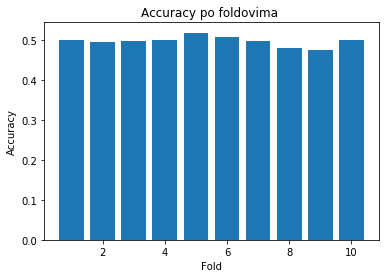

In [20]:
accuracy_by_k_folds = scores['test_accuracy']
plt.bar(np.arange(1, k+1), accuracy_by_k_folds)
plt.title('Accuracy po foldovima ')
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.show()

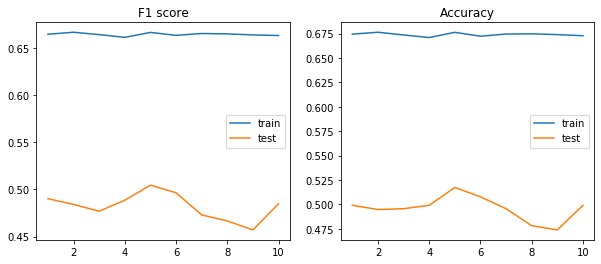

In [21]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('F1 score')
plt.plot(np.arange(1, k+1), scores['train_f1_macro'], label='train')
plt.plot(np.arange(1, k+1), scores['test_f1_macro'], label='test')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(1, k+1), scores['train_accuracy'], label='train')
plt.plot(np.arange(1, k+1), scores['test_accuracy'], label='test')
plt.legend(loc='best')

### Podela podataka na trening i testni skup

In [23]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 1996)

In [24]:
scaler_train = preprocessing.StandardScaler()
scaler_train.fit(X_train)
X_train_knn = scaler_train.transform(X_train)
X_test_knn = scaler_train.transform(X_test)

In [25]:
grid = model_selection.GridSearchCV(KNeighborsClassifier(), param_grid=knn_par, scoring='accuracy', cv=10, return_train_score=True)

In [26]:
grid.fit(X_train_knn, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None, param_grid={'n_neighbors': [3, 5, 7, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [27]:
grid.best_params_

{'n_neighbors': 3}

In [28]:
grid.cv_results_

{'mean_fit_time': array([0.14983709, 0.15139689, 0.14924355, 0.15112674]),
 'std_fit_time': array([0.01055984, 0.00420342, 0.00235717, 0.00323558]),
 'mean_score_time': array([4.03119984, 4.0250205 , 3.98955569, 4.03207934]),
 'std_score_time': array([0.02588119, 0.02839477, 0.02230582, 0.04811877]),
 'param_n_neighbors': masked_array(data=[3, 5, 7, 9],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3},
  {'n_neighbors': 5},
  {'n_neighbors': 7},
  {'n_neighbors': 9}],
 'split0_test_score': array([0.47826087, 0.46832298, 0.44968944, 0.43726708]),
 'split1_test_score': array([0.4621118 , 0.4447205 , 0.42732919, 0.42360248]),
 'split2_test_score': array([0.46459627, 0.43726708, 0.42857143, 0.40496894]),
 'split3_test_score': array([0.46956522, 0.47204969, 0.45714286, 0.43602484]),
 'split4_test_score': array([0.4484472 , 0.43975155, 0.42484472, 0.42484472]),
 'split5_test_score': array([0.45590062, 0.448447

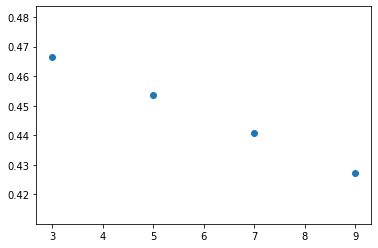

In [53]:
plt.scatter(grid.param_grid.values(), grid.cv_results_['mean_test_score'])

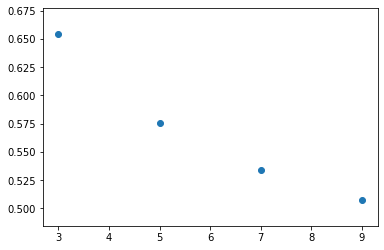

In [54]:
plt.scatter(grid.param_grid.values(), grid.cv_results_['mean_train_score'])

In [29]:
best_model = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
best_model.fit(X_train_knn, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [30]:
y_pred = best_model.predict(X_test_knn)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.72      0.83       690
           2       0.35      0.67      0.46       690
           3       0.37      0.63      0.47       690
           4       0.90      0.28      0.43       690
           5       0.27      0.09      0.13       690

    accuracy                           0.48      3450
   macro avg       0.57      0.48      0.46      3450
weighted avg       0.57      0.48      0.46      3450



In [31]:
cm = metrics.confusion_matrix(y_test, y_pred, classes)
print(cm)

[[497 108  59  21   5]
 [  6 460 211   0  13]
 [  1 235 438   1  15]
 [  0 184 180 193 133]
 [  0 328 302   0  60]]


(5.0, 0.0)

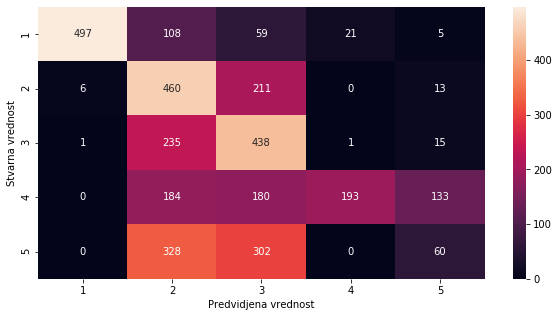

In [32]:
import seaborn
df_cm = pd.DataFrame(cm, index = classes, columns=classes)
plt.figure(figsize = (10, 5))
ax = seaborn.heatmap(df_cm, annot=True, fmt="d")
ax.set_ylabel('Stvarna vrednost')
ax.set_xlabel('Predvidjena vrednost')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [33]:
final_model = KNeighborsClassifier(n_neighbors= grid.best_params_['n_neighbors'])
final_model.fit(X_knn, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [35]:
import joblib
joblib.dump(final_model, 'knn_model.joblib')

['knn_model.joblib']

## Furijeova transformacija podataka

In [36]:
X_knn_fft = np.fft.rfft(X_knn, axis=1).astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [37]:
X_knn_fft.shape

(11500, 90)

### Ugnježđena unakrsna validacija

In [38]:
scores_fft = model_selection.cross_validate(model_selection.GridSearchCV(KNeighborsClassifier(), param_grid=knn_par, cv=k),\
                                         X_knn_fft, y, scoring=scoring, cv= k, return_train_score=True)

In [39]:
scores_fft = pd.DataFrame(scores_fft)
scores_fft.to_csv('kNN_fft_scoring_results.csv')
print(scores_fft)

     fit_time  score_time  test_f1_macro  train_f1_macro  test_accuracy  \
0  125.100386   24.690894       0.463118        0.676012       0.460870   
1  125.619709   24.463188       0.478332        0.676797       0.482609   
2  125.548625   24.964564       0.450710        0.669964       0.452174   
3  122.418953   23.991990       0.462421        0.674119       0.461739   
4  122.992603   23.913206       0.491908        0.675565       0.486957   
5  122.960202   23.941294       0.476194        0.673765       0.479130   
6  123.917390   24.172017       0.488715        0.670843       0.492174   
7  123.690928   24.163566       0.464383        0.673539       0.469565   
8  125.701959   24.764277       0.465887        0.674262       0.466087   
9  124.886993   24.241044       0.491410        0.672266       0.490435   

   train_accuracy  test_f1_class_1  train_f1_class_1  test_f1_class_2  \
0        0.676715         0.786632          0.930328         0.425197   
1        0.677585         0.

In [40]:
scores_fft.mean(axis=0)

fit_time            124.283775
score_time           24.330604
test_f1_macro         0.473308
train_f1_macro        0.673713
test_accuracy         0.474174
train_accuracy        0.674493
test_f1_class_1       0.831359
train_f1_class_1      0.929771
test_f1_class_2       0.434855
train_f1_class_2      0.611133
test_f1_class_3       0.437886
train_f1_class_3      0.661636
test_f1_class_4       0.442720
train_f1_class_4      0.644323
test_f1_class_5       0.219718
train_f1_class_5      0.521702
dtype: float64

In [41]:
scores_fft.mean(axis=0)['test_accuracy']

0.4741739130434783

In [42]:
scores_fft.mean(axis=0)['test_f1_macro']

0.47330767818994185

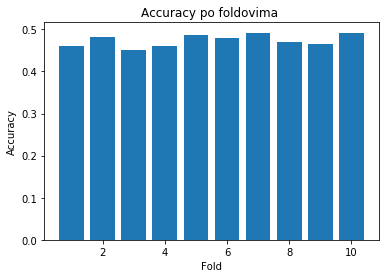

In [43]:
accuracy_by_k_folds = scores_fft['test_accuracy']
plt.bar(np.arange(1, k+1), accuracy_by_k_folds)
plt.title('Accuracy po foldovima ')
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.show()

In [44]:
np.arange(1, number_of_classes+1)

array([1, 2, 3, 4, 5])

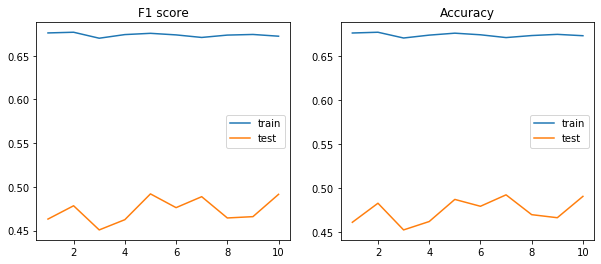

In [45]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('F1 score')
plt.plot(np.arange(1, k+1), scores_fft['train_f1_macro'], label='train')
plt.plot(np.arange(1, k+1), scores_fft['test_f1_macro'], label='test')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(1, k+1), scores_fft['train_accuracy'], label='train')
plt.plot(np.arange(1, k+1), scores_fft['test_accuracy'], label='test')
plt.legend(loc='best')

### Podela podataka na trening i testni skup

In [46]:
X_fft_train, X_fft_test, y_train, y_test = model_selection.train_test_split(X_knn_fft, y, test_size = 0.3, stratify = y, random_state = 1996)

In [47]:
grid = model_selection.GridSearchCV(KNeighborsClassifier(), param_grid=knn_par, scoring='accuracy', cv=10, return_train_score=True)

In [48]:
grid.fit(X_fft_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None, param_grid={'n_neighbors': [3, 5, 7, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [49]:
grid.best_params_

{'n_neighbors': 3}

In [50]:
grid.cv_results_

{'mean_fit_time': array([0.06142564, 0.06379929, 0.06475863, 0.06421111]),
 'std_fit_time': array([0.00933951, 0.00184249, 0.00222697, 0.00244803]),
 'mean_score_time': array([1.56779895, 1.61312177, 1.61698592, 1.64202287]),
 'std_score_time': array([0.02448372, 0.03780404, 0.02391622, 0.02067034]),
 'param_n_neighbors': masked_array(data=[3, 5, 7, 9],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3},
  {'n_neighbors': 5},
  {'n_neighbors': 7},
  {'n_neighbors': 9}],
 'split0_test_score': array([0.44347826, 0.45217391, 0.4484472 , 0.44720497]),
 'split1_test_score': array([0.4484472 , 0.4310559 , 0.42981366, 0.43975155]),
 'split2_test_score': array([0.42360248, 0.42732919, 0.41987578, 0.40993789]),
 'split3_test_score': array([0.47329193, 0.45217391, 0.44596273, 0.43975155]),
 'split4_test_score': array([0.43975155, 0.43478261, 0.40869565, 0.40496894]),
 'split5_test_score': array([0.45341615, 0.438509

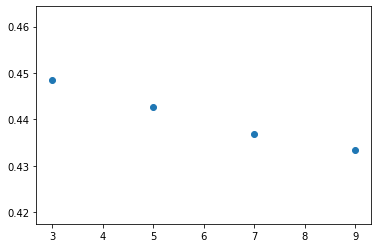

In [51]:
plt.scatter(grid.param_grid.values(), grid.cv_results_['mean_test_score'])

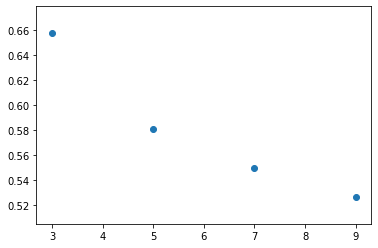

In [52]:
plt.scatter(grid.param_grid.values(), grid.cv_results_['mean_train_score'])

In [54]:
best_model = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
best_model.fit(X_fft_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [57]:
y_pred = best_model.predict(X_fft_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.98      0.71      0.82       690
           2       0.32      0.60      0.42       690
           3       0.37      0.56      0.45       690
           4       0.79      0.31      0.44       690
           5       0.37      0.18      0.24       690

    accuracy                           0.47      3450
   macro avg       0.57      0.47      0.47      3450
weighted avg       0.57      0.47      0.47      3450



In [58]:
cm = metrics.confusion_matrix(y_test, y_pred, classes)
print(cm)

[[489 103  52  41   5]
 [  9 416 239   4  22]
 [  2 274 387   3  24]
 [  0 178 143 211 158]
 [  0 342 216   9 123]]


(5.0, 0.0)

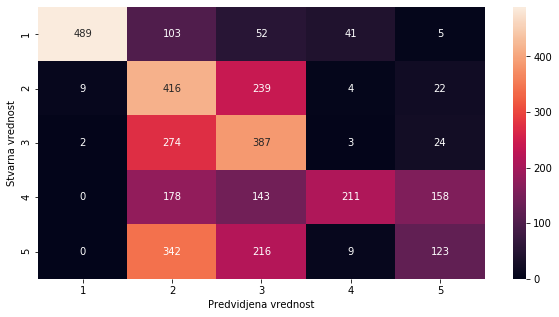

In [60]:
import seaborn
df_cm = pd.DataFrame(cm, index = classes, columns=classes)
plt.figure(figsize = (10, 5))
ax = seaborn.heatmap(df_cm, annot=True, fmt="d")
ax.set_ylabel('Stvarna vrednost')
ax.set_xlabel('Predvidjena vrednost')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [61]:
final_model_fft = KNeighborsClassifier(n_neighbors= grid.best_params_['n_neighbors'])
final_model_fft.fit(X_knn_fft, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [62]:
import joblib
joblib.dump(final_model_fft, 'knn_fft_model.joblib')

['knn_fft_model.joblib']